# Flow-shop scheduling
---
Problem polegający na kolejkowaniu zadań wykonywanych sekwencyjnie na kolejnych maszynach.

## Wczytanie danych

In [2]:
import flow_shop as fs
# Config dataset
path_ds    = 'database/tai20_10.txt'
nth_set_ds = 1
df = fs.DatasetReader(path_ds).read_data(nth_set_ds)

## Wizualizacja problemu

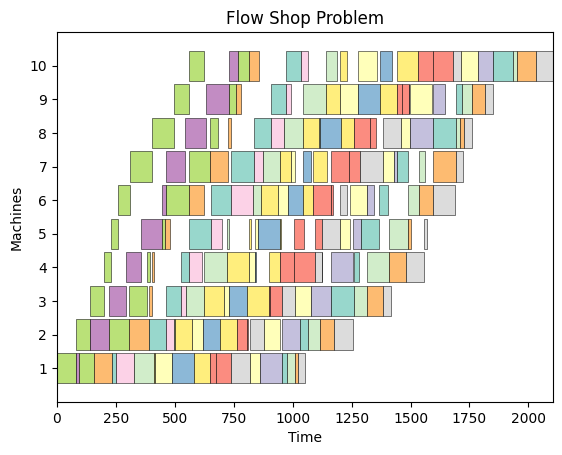

In [3]:
#Read and display data 
c_t, c_a = fs.calculate_completion_time(df, return_comp_arr=True)
fs.display_graph(df, c_t, c_a)

## Tabu Search
---
Algorytm bazujący na przeszukiwaniu sąsiedztwa. *Lista tabu* umożliwia wyjście z ekstremum lokalnego.

![Tabu Search Flow Diagram](doc/img/TabuSearch.png "Tabu Search")

### Test algorytmu Tabu Search

In [15]:
import metaheuristic.tabu_search as ts
import matplotlib.pyplot as plt
import flow_shop as fs
import numpy as np
import time

# Test Tabu Search algorithm for all type neighborhoods 
for m_t in ts.NeighborMoves:
    # Algorithm config 
    data             = df.processing_time
    move_type        = m_t
    tabu_size        = 6
    aspiration_value = 10
    max_iter         = 500
    t_start          = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

    t = time.process_time()                 # Time measure
    t_best, x_best = ts.tabu_search(data,   # Run algorithm
                                    move_type=move_type, 
                                    tabu_size=tabu_size, 
                                    aspiration_value=aspiration_value, 
                                    max_iter=max_iter, 
                                    return_hist=False)

    elapsed_time = time.process_time() - t  # Time measure

    # Display results
    print("Tabu Search:")
    print("\t move type: {}".format(ts.TRANSFORMS_NAME[move_type.value]))
    print("\t iteration: {}".format(max_iter))
    print("\t tabu list size: {}".format(tabu_size))
    print("\t aspiration criteria: {}".format(aspiration_value))
    print("\t {:.^20}".format('RESULT'))
    print("\t Starting time: {}".format(t_start))
    print("\t Up bound: {}".format(df.up_bound))
    print("\t Best time: {}".format(t_best))
    print("\t {:.^20}".format('ALGORITHM'))
    print("\t Time: {}".format(elapsed_time))

Tabu Search:
	 move type: SWAP
	 iteration: 500
	 tabu list size: 6
	 aspiration criteria: 10
	 .......RESULT.......
	 Starting time: 2104.0
	 Up bound: 1659
	 Best time: 1711.0
	 .....ALGORITHM......
	 Time: 11.434525928
Tabu Search:
	 move type: Reverse Subsequence
	 iteration: 500
	 tabu list size: 6
	 aspiration criteria: 10
	 .......RESULT.......
	 Starting time: 2104.0
	 Up bound: 1659
	 Best time: 1723.0
	 .....ALGORITHM......
	 Time: 10.710657319000006
Tabu Search:
	 move type: Insert Before
	 iteration: 500
	 tabu list size: 6
	 aspiration criteria: 10
	 .......RESULT.......
	 Starting time: 2104.0
	 Up bound: 1659
	 Best time: 1698.0
	 .....ALGORITHM......
	 Time: 11.238055497000005
Tabu Search:
	 move type: Insert After
	 iteration: 500
	 tabu list size: 6
	 aspiration criteria: 10
	 .......RESULT.......
	 Starting time: 2104.0
	 Up bound: 1659
	 Best time: 1682.0
	 .....ALGORITHM......
	 Time: 11.237760126000012


### Uzyskane wyniki Tabu Search

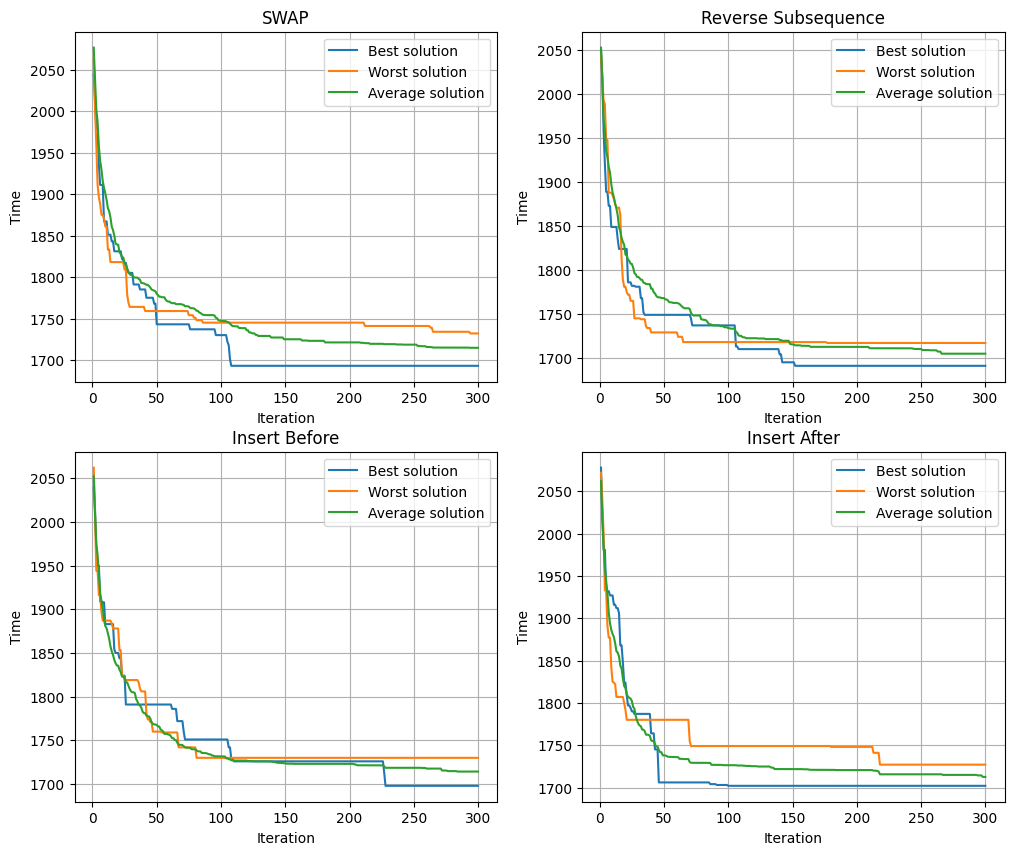

In [16]:
import metaheuristic.tabu_search as ts
import matplotlib.pyplot as plt
import flow_shop as fs
import numpy as np

n = 10
max_iter = 300
full_hist = np.zeros((4,n,max_iter))

for i in range(n):
    data = df.processing_time.copy()
    np.random.shuffle(data.T)

    for j, m_t in enumerate(ts.NeighborMoves):
        data             = df.processing_time
        move_type        = m_t
        tabu_size        = 6
        aspiration_value = 10
        max_iter         = max_iter

        t_start = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

        t_best, x_best, t_hist = ts.tabu_search(data, 
                                        move_type=move_type, 
                                        tabu_size=tabu_size, 
                                        aspiration_value=aspiration_value, 
                                        max_iter=max_iter, 
                                        return_hist=True)

        full_hist[j,i,:] = t_hist[:,0]

fig = plt.figure()
fig.set_size_inches(12,10)
for i, m_t in enumerate(ts.NeighborMoves):
    part_hist = full_hist[m_t.value]
    min = np.argmin(part_hist[:,-1])
    max = np.argmax(part_hist[:,-1])

    plt.subplot(2,2,i+1)
    plt.plot(range(1,max_iter+1),part_hist[min,:], label="Best solution")
    plt.plot(range(1,max_iter+1),part_hist[max,:], label="Worst solution")
    plt.plot(range(1,max_iter+1),np.average(part_hist, axis=0), label="Average solution")
    plt.title(ts.TRANSFORMS_NAME[i])
    plt.xlabel('Iteration')
    plt.ylabel('Time')
    plt.grid()
    plt.legend()
    
plt.show()

## Simulated Annealing
---

<p align='center'>
    <img src='doc/img/simulated_annealing.jpg' width ='500px'>
</p>

Simulated Annealing:
	 move type: Insert After
	 slope function: Geometric
	 initial temperature: 1145.5264413834714
	 iteration: 5000
	 .......RESULT.......
	 Starting time: 2104.0
	 Best time: 1702.8
	 Up bound: 1659
	 .....ALGORITHM......
	 Time: 6.3634477929999775


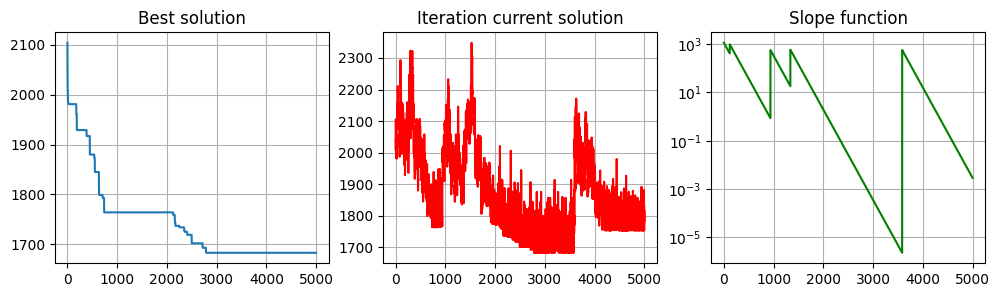

In [18]:
import metaheuristic.simulated_annealing as sa
import matplotlib.pyplot as plt
import flow_shop as fs
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

# Config algorithm parameters
data       = df.processing_time.copy()  # np.random.shuffle(data.T)
move_type  = sa.NeighborMoves.INSERT_AFTER
slope_type = sa.SlopeType.GEOMETRIC
temp_init  = sa.assign_temp_init(5, 0.99)
max_iter   = int(5e3)
t_start    = fs.calculate_completion_time(data, data.shape[1], data.shape[0])
N_iter = 10

avg_time = 0
for i in range(N_iter):
    t = time.process_time() # Time measure
    t_best, x_best, hist = sa.simulated_annealing(data,       # Run algorithm
                                                move_type=move_type, 
                                                slope_type=slope_type,
                                                temp_init=temp_init,
                                                max_iter=max_iter,
                                                return_hist=True,
                                                pulse_temp=True)

    elapsed_time = time.process_time() - t # Time measure
    avg_time += t_best
avg_time /= N_iter

# Display results
slope_to_str = ['Geometric', 'Logarithmic', 'Linear']
print("Simulated Annealing:")
print("\t move type: {}".format(sa.TRANSFORMS_NAME[move_type.value]))
print("\t slope function: {}".format(slope_to_str[slope_type.value]))
print("\t initial temperature: {}".format(temp_init))
print("\t iteration: {}".format(max_iter))
print("\t {:.^20}".format('RESULT'))
print("\t Starting time: {}".format(t_start))
print("\t Best time: {}".format(avg_time))
print("\t Up bound: {}".format(df.up_bound))
print("\t {:.^20}".format('ALGORITHM'))
print("\t Time: {}".format(elapsed_time))

fig = plt.figure()
fig.set_size_inches(12,3)
sub_title = ['Best solution', 'Iteration current solution', 'Slope function']
color = ['C0', 'r', 'g']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(hist[:,i], color[i])
    plt.title(sub_title[i])
    plt.grid()

plt.yscale('log')
plt.show()

## Threshold algorithm
---

100
Threshold Algorithm:
	 move type: SWAP
	 fall function: Logarithmic
	 initial temperature: 1000
	 iteration: 5000
	 .......RESULT.......
	 Starting time: 4730.0
	 Best time: 3929.0
	 Up bound: 3715
	 .....ALGORITHM......
	 Time: 30.513888665999996


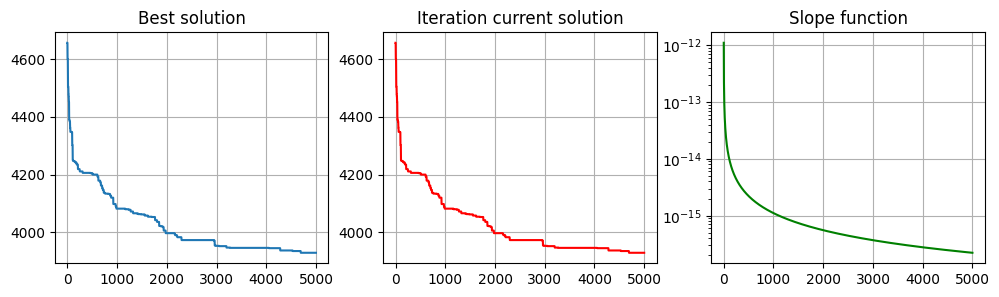

In [3]:
import metaheuristic.threshold_algorithm as ta
import matplotlib.pyplot as plt
import flow_shop as fs
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

# Config algorithm parameters
data       = df.processing_time.copy()    #np.random.shuffle(data.T)
slope_type = ta.SlopeType.LOGARITHMIC
move_type  = ta.NeighborMoves.SWAP
max_iter   = int(5e3)
temp_init  = 1000
t_start    = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

t = time.process_time() # Time measure
t_best, x_best, hist = ta.threshold_algorithm(data,  # Run algorithm
                                            move_type=move_type, 
                                            slope_type=slope_type,
                                            temp_init=temp_init,
                                            max_iter=max_iter,
                                            return_hist=True,
                                            pulse_temp=True)

elapsed_time = time.process_time() - t # Time measure

# Display results
slope_to_str = ['Geometric', 'Logarithmic', 'Linear']
print("Threshold Algorithm:")
print("\t move type: {}".format(ta.TRANSFORMS_NAME[move_type.value]))
print("\t fall function: {}".format(slope_to_str[slope_type.value]))
print("\t initial temperature: {}".format(temp_init))
print("\t iteration: {}".format(max_iter))
print("\t {:.^20}".format('RESULT'))
print("\t Starting time: {}".format(t_start))
print("\t Best time: {}".format(t_best))
print("\t Up bound: {}".format(df.up_bound))
print("\t {:.^20}".format('ALGORITHM'))
print("\t Time: {}".format(elapsed_time))

fig = plt.figure()
fig.set_size_inches(12,3)
sub_title = ['Best solution', 'Iteration current solution', 'Slope function']
color = ['C0', 'r', 'g']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(hist[:,i], color[i])
    plt.title(sub_title[i])
    plt.grid()

plt.yscale('log')
plt.show()

## RVNS
---

In [8]:
import metaheuristic.reduced_vns as rvns
import flow_shop as fs
import time

data       = df.processing_time.copy()
t_start = fs.calculate_completion_time(df)

rvns_param = {
    'k_prime': 100,
    'k_bis':   30,
}

t = time.process_time() # Time measure
t_best, x_best = rvns.reduced_variable_neighborhood_search( df.processing_time, rvns_param['k_prime'], rvns_param['k_bis'] )
elapsed_time = time.process_time() - t # Time measure

print("Reduced Variable Neighborhood Search:")
print("\t k' iteration: {}".format(rvns_param['k_prime']))
print("\t k'' iteration: {}".format(rvns_param['k_bis']))
print("\t {:.^20}".format('RESULT'))
print("\t Starting time: {}".format(t_start))
print("\t Best time: {}".format(t_best))
print("\t Up bound: {}".format(df.up_bound))
print("\t {:.^20}".format('ALGORITHM'))
print("\t Time: {}".format(elapsed_time))


Reduced Variable Neighborhood Search:
	 k' iteration: 100
	 k'' iteration: 30
	 .......RESULT.......
	 Starting time: 2104.0
	 Best time: 1720.0
	 Up bound: 1659
	 .....ALGORITHM......
	 Time: 3.7556003150000006
